# SQL Generation and Analysis Workflow Test

This notebook demonstrates the complete workflow using LLM:
1. SQL Generation
2. Extracting entities from the generated SQL
3. Matching entities against database
4. Refining the generated SQL
5. Executing the refined SQL
6. Analyzing the results
7. Visualizing the results

In [1]:
from llm_config.llm_call import generate_text

In [2]:
# Test queries
test_queries = [
"""Give me a list of inspections scheduled for fair price shops in district UID 220, with the district name, sub-division, block, shop ID, and when the inspection was scheduled. Sort them by date.""",
"""List all the blocks that belong to district UID 217, sorted alphabetically.""",
"""Give a daily count of surveys conducted in each district from February 1, 2025 onwards, grouped by district and date.""",
"""Give a list of all users who did surveys from February 18, 2025, onwards, along with their name, mobile number, the fair price shop they surveyed, and the location details like panchayat, block, and district. Sort by username and survey date.""",
"""Give the CMR Godown Inspection Report with the following parameters:
{
    "startDate": "2025-04-01",
    "endDate": "2025-04-30",
 }
"""
]

# Select which query to test
user_query = test_queries[4]

print(user_query)

Give the CMR Godown Inspection Report with the following parameters:
{
    "startDate": "2025-04-01",
    "endDate": "2025-04-30",
 }



## 1. SQL Generation Test

In [3]:
from engine.generator import SQLGenerator

def test_generator(query, model="gemini"):
    """Test SQL generation functionality with single LLM and validation"""
    generator = SQLGenerator()
    
    try:
        # Generate SQL
        print("\nGenerating SQL:")
        results = generator.main_generator(query, llm_model=model)
        print("\nGenerated SQL:", results['generated_sql'])
        return results['generated_sql']
        
    except Exception as e:
        print(f"Error: {str(e)}")
        return None

generated_sql = test_generator(user_query)


Generating SQL:

Schema:
 Table: admin_permissions
Columns:
  - id (integer)
  - action (character varying)
  - action_parameters (jsonb)
  - subject (character varying)
  - properties (jsonb)
  - conditions (jsonb)
  - created_at (timestamp without time zone)
  - updated_at (timestamp without time zone)
  - created_by_id (integer)
  - updated_by_id (integer)
  - document_id (character varying)
  - locale (character varying)
  - published_at (timestamp without time zone)

Table: admin_permissions_role_lnk
Columns:
  - id (integer)
  - permission_id (integer)
  - role_id (integer)
  - permission_ord (double precision)

Table: admin_roles
Columns:
  - id (integer)
  - name (character varying)
  - code (character varying)
  - description (character varying)
  - created_at (timestamp without time zone)
  - updated_at (timestamp without time zone)
  - created_by_id (integer)
  - updated_by_id (integer)
  - document_id (character varying)
  - locale (character varying)
  - published_at (tim

## 2. Entity Extraction Test

In [4]:
from engine.entity_extractor import EntityExtractor

def test_entity_extractor(sql_query, model="gemini"):
    """Test entity extraction functionality with single LLM and validation"""
    extractor = EntityExtractor()
    
    try:
        # Extract entities
        print("\nExtracting entities:")
        results = extractor.main_entity_extractor(sql_query, llm_model=model)
        print("\nExtracted Entities:")
        for entity in results:
            print("---")
            print(f"Table: {entity['table']}")
            print(f"Column: {entity['column']}")
            print(f"Value: {entity['value']}")
        return results
        
    except Exception as e:
        print(f"Error: {str(e)}")
        return None

extracted_entities = test_entity_extractor(generated_sql)


Extracting entities:

Extracted Entities:
---
Table: survey_types
Column: type
Value: CMR


## 3. Value Matching Test

In [5]:
from engine.value_matcher import ValueMatcher

def test_value_matcher(extracted_entities):
    """Test value matching functionality"""
    matcher = ValueMatcher()
    
    try:
        value_mappings = []
        for entity in extracted_entities:
            match = matcher.main_value_matcher(entity)
            value_mappings.extend(match)
        
        print("Value Mappings:")
        for mapping in value_mappings:
            print("---")
            print(f"Original: '{mapping['original_value']}'")
            print(f"Matched: '{mapping['matched_value']}'")
            print(f"Score: {mapping['score']}")
        
        return value_mappings
        
    except Exception as e:
        print(f"Error: {str(e)}")
        return None

value_mappings = test_value_matcher(extracted_entities)

Value Mappings:
---
Original: 'CMR'
Matched: 'CMR'
Score: 100


## 4. SQL Refinement Test

In [6]:
from engine.refiner import SQLRefiner

def test_refiner(sql_query, value_mappings, model="gemini"):
    """Test SQL refinement functionality with single LLM and validation"""
    refiner = SQLRefiner()
    
    try:
        # Refine SQL
        print("\nRefining SQL:")
        results = refiner.main_refiner(sql_query, value_mappings, llm_model=model)
        print("\nRefined SQL:", results['refined_sql'])
        return results['refined_sql']
        
    except Exception as e:
        print(f"Error: {str(e)}")
        return None

refined_sql = test_refiner(generated_sql, value_mappings)


Refining SQL:

Refined SQL: SELECT
  surveys.document_id AS survey_document_id,
  surveys.start_latitude,
  surveys.start_longitude,
  surveys.end_latitude,
  surveys.end_longitude,
  surveys.start_time,
  surveys.end_time,
  surveys.beneficiary_count,
  surveys.created_at AS survey_created_at,
  surveys.updated_at AS survey_updated_at,
  surveys.published_at AS survey_published_at,
  surveys.prev_issues,
  surveys.new_issues,
  surveys.last_inspection_details,
  surveys.report_url,
  godowns.godown_id,
  godowns.godown_name,
  godowns.address AS godown_address,
  godowns.ownership,
  godowns.capacity,
  godowns.latitude AS godown_latitude,
  godowns.longitude AS godown_longitude,
  godowns.current_status,
  godowns.last_inspection_details AS godown_last_inspection_details,
  godowns.godown_4_g_id,
  poims_users.username AS surveyor_username,
  poims_users.email AS surveyor_email,
  poims_users.fullname AS surveyor_fullname,
  districts.district_name,
  sub_divisions.sub_division_name

## 5. SQL Execution Test

In [7]:
from engine.executor import SQLExecutor

def test_executor(sql_query):
    """Test SQLExecutor functionality"""
    executor = SQLExecutor()
    
    success, results, formatted_results, error = executor.main_executor(sql_query)
    
    if success:
        print(f"\nSuccess! Found {len(results)} rows")
        print("\nFormatted Results:")
        print(formatted_results)
        print("\nRaw Results:")
        print(results)
        return results
    else:
        print(f"\nFailed: {error}")
        return None

execution_results = test_executor(refined_sql)


Success! Found 19 rows

Formatted Results:
survey_document_id       | start_latitude | start_longitude | end_latitude | end_longitude | start_time                 | end_time                   | beneficiary_count | survey_created_at          | survey_updated_at          | survey_published_at        | prev_issues | new_issues | last_inspection_details | report_url | godown_id  | godown_name                                                         | godown_address                                                                                                                                  | ownership | capacity | godown_latitude | godown_longitude | current_status | godown_last_inspection_details | godown_4_g_id | surveyor_username | surveyor_email               | surveyor_fullname | district_name   | sub_division_name | block_name | panchayat_name                                    
--------------------------------------------------------------------------------------------------------

## 6. Results Analysis Test

In [8]:
from engine.analyzer import SQLAnalyzer

def test_analyzer(query, results):
    """Test SQLAnalyzer functionality"""
    analyzer = SQLAnalyzer()
    
    try:
        # Analyze results
        print("\nAnalyzing results:")
        results = analyzer.main_analyzer(query, results, llm_model="gemini")
        print("\nAnalysis: ", results['analysis'])
        
    except Exception as e:
        print(f"Error: {str(e)}")

test_analyzer(user_query, execution_results)


Analyzing results:

Analysis:  Here's a comprehensive analysis of the provided CMR Godown Inspection Report data:

**1. Key Findings and Patterns:**

*   **Geographic Distribution:** Inspections are concentrated in a few districts, notably Arwal, Begusarai, Aurangabad, Araria, Banka, Darbhanga and Kaimur (Bhabua). This suggests a targeted inspection strategy or potentially higher activity in these regions.
*   **Godown Ownership:** The majority of godowns inspected are owned by "Nigam," indicating a significant reliance on this entity for storage. A smaller portion is "Rented."
*   **Surveyor Activity:** "Dayakar B" and "AshaK" appear to be the primary surveyors, with multiple inspections attributed to each. "Munay Kumar Singh" also appears.
*   **Inspection Dates:** Inspections are clustered around specific dates within the April 2025 timeframe, suggesting scheduled inspection campaigns.
*   **Godown Capacity:** Godown capacities vary widely, ranging from 200 to 5000, indicating a mi

## 7. Results Visualization Test

Generating visualizations:

Generated visualization code: import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'execution_results' contains the data from the SQL query
# execution_results = ...  # Replace with your actual data

df = pd.DataFrame(execution_results)

# Convert relevant columns to appropriate data types
df['start_time'] = pd.to_datetime(df['start_time'])
df['end_time'] = pd.to_datetime(df['end_time'])
df['capacity'] = pd.to_numeric(df['capacity'])

# 1. Number of Inspections per District
plt.figure()
district_counts = df['district_name'].value_counts()
sns.barplot(x=district_counts.index, y=district_counts.values)
plt.title('Number of Inspections per District')
plt.xlabel('District')
plt.ylabel('Number of Inspections')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
plt.close()

# 2. Inspections per Surveyor
plt.figure()
surveyor_counts = df['surveyor_fullname'].value_counts()
sns.barplot(x=surveyor_counts.index, y=survey

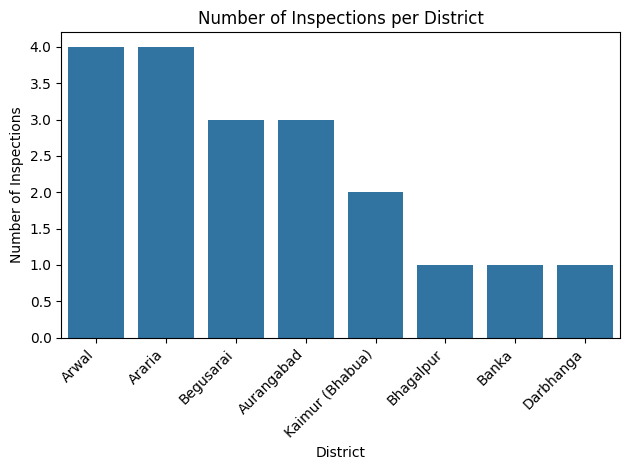

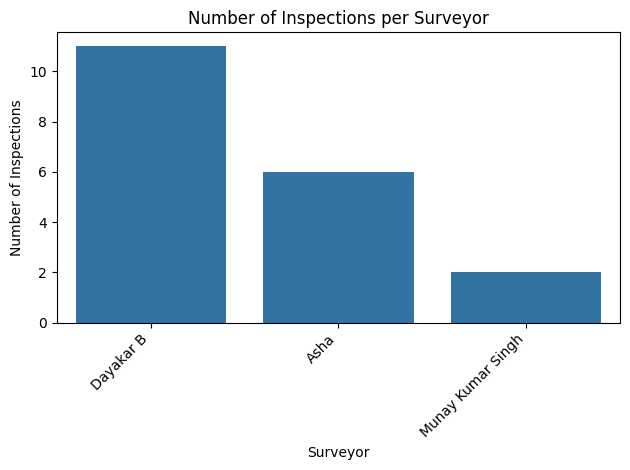

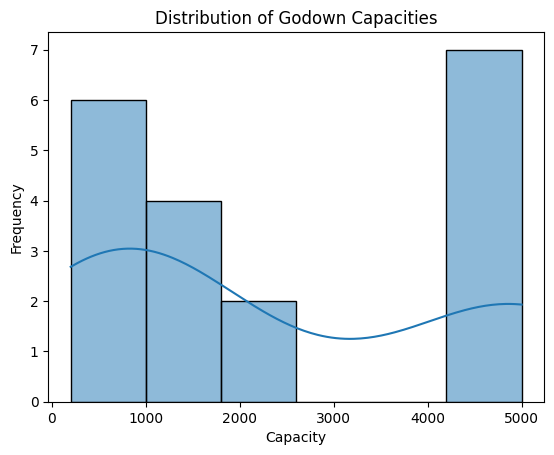

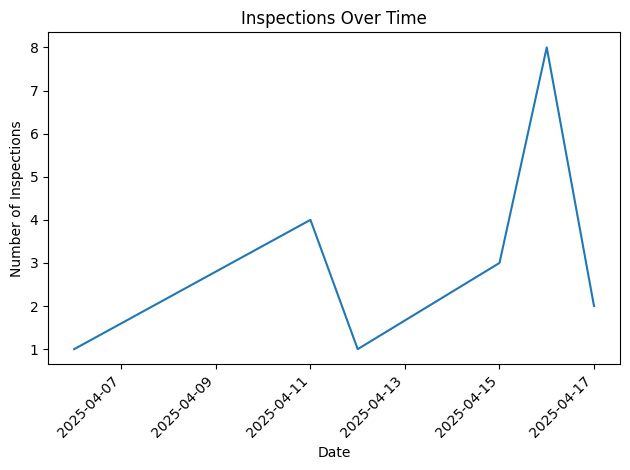

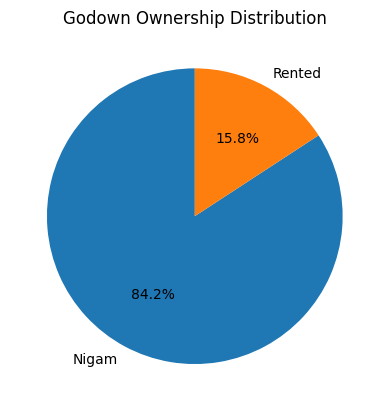

In [9]:
from engine.visualizer import SQLVisualizer

def test_visualizer(query, results):
    """Test SQLVisualizer functionality"""
    visualizer = SQLVisualizer()
    
    try:
        # Generate visualizations
        print("Generating visualizations:")
        results = visualizer.main_visualizer(query, results, llm_model="gemini")
        print("\nGenerated visualization code:", results["generated_code"])
        return results["generated_code"]
            
    except Exception as e:
        print(f"Error: {str(e)}")

visualization_code = test_visualizer(user_query, execution_results)

exec(visualization_code)